# Navigation

---

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

The next code cell demonstrates how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Later we are going to implement the **DQN** agent to get better results

In [14]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: -1.0


# Building the Agent

#### Importing usual packages 

In [5]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import deque,namedtuple
import random

## 5. Defining the Deep Neural Network 
The following cell defines the neural network architecture . 
It uses 3 fully connected layers 
the hidden layers have size **64** and **32** , and has **RELU** activation applied to it

In [6]:
class Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,4)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 6. Building the agent using Deep Q Network
The following cell implements the agent using the [DQN](https://www.nature.com/articles/nature14236) technique . 
The agent recieves the enviorement information and learn from it .

### Some Hyperparamerters list :-
1. **epsilon**  = 1 *decays gradually*
2. **gamma** = 0.99
3. **batch size** = 32 (for experience replay)
4. **Optimizer** = ADAM
5. **Learning rate**  = 0.001
6. **buffer size** = $10^5$
7. **Tau** = $10^-3$

In [7]:
class Agent():
    def __init__(self,input_size,output_size):
        
        # Some hyperparameters
        self.epsilon=1
        self.eps_decay = 0.9
        self.gamma = 0.99
        self.input_size = input_size
        self.action_size = output_size
        self.batch_size = 32
        self.q_network = Network(self.input_size,self.action_size)
        self.q_network_target = Network(self.input_size,self.action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(),lr=0.001)
        
        self.buffer_size = int(1e5)
        
        self.memory = deque(maxlen=self.buffer_size)
        
        self.time_step = 0
        self.update_every = 4
        
        self.tau = 1e-3
    def act(self,state,epsilon=None):
        self.epsilon*=self.eps_decay
        epsilon = self.epsilon 
        self.q_network.eval()
        state = torch.from_numpy(state).float().view(1,*state.shape)
        with torch.no_grad():
            val = self.q_network(state)
            if epsilon is not None and random.random()<epsilon:
                return np.random.choice(np.arange(self.action_size))
            else:
                return np.argmax(val.data.numpy()).astype(np.int32)
    def step(self,state,action,reward,done,next_state):
        experience = (state,action,reward,done,next_state)
        self.memory.append(experience)
        
        self.time_step = (self.time_step+1)%self.update_every
        
        if self.time_step == 0:
            if len(self.memory) > self.batch_size :
                self.train()
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return (states, actions, rewards, next_states, dones)
    def train(self):
        states,actions,rewards,next_states,dones = self.sample()
        self.q_network.train()
        
        Q_actual = self.q_network(states).gather(1,actions)
        q_val = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_target = rewards + self.gamma*(q_val)*(1-dones)
        
        loss = F.mse_loss(Q_actual,Q_target)
        self.optimizer.zero_grad()
        
        loss.backward()
        self.optimizer.step()
        
        self.soft_update()
    def soft_update(self):
        ## θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(self.q_network_target.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

In [8]:
agent = Agent(state_size,action_size)

### Watch the untrained network play 
Run the cell below to see the untrained neural network play . It would be like the agent is picking the action at random 

In [9]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for _ in range(1000):
    action = agent.act(state)      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


## 7. Implementing the Q-Learning algorithm 
The following code cell implements the **Q-Learning** Algorithm to train the agent 
We train it from **1000** episodes . 

It produces an avearge score of around **14-16** after 1000 episode .To solve the enviorement we needed an average score of **13** . 

In [57]:
rewards_per_ep = []
for i in range(1,1001):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    avg_reward = 0
    score = 0.0
    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score+=reward
        agent.step(state,action,reward,done,next_state)
        state = next_state
        if done:
            break
    rewards_per_ep.append(score)
    avg_reward = np.mean(rewards_per_ep)
    print("\rEpisode {}    avg_reward = {:3f}  ".format(i,avg_reward),end="")
    if i > 100 :
        reward_100 = np.mean(rewards_per_ep[-100:])
        print("Avg reward of last 100 episodes : {:3f}".format(np.mean(reward_100)),end="")
    if i % 200 == 0:
        print()

Episode 200    avg_reward = 1.015000  Avg reward of last 100 episodes : 2.04000000
Episode 400    avg_reward = 3.630000  Avg reward of last 100 episodes : 6.120000
Episode 600    avg_reward = 6.133333  Avg reward of last 100 episodes : 12.650000
Episode 800    avg_reward = 8.195000  Avg reward of last 100 episodes : 14.420000
Episode 1000    avg_reward = 9.728000  Avg reward of last 100 episodes : 16.110000


## 8. Visualize the Score achieved by the Ai at each episode 
You can see the scores slowly increases as the agent optimizer its stratergy

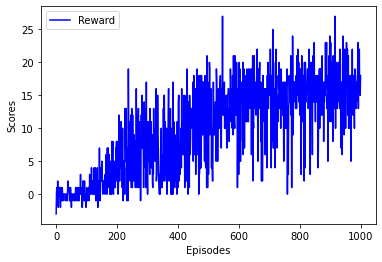

In [64]:
%matplotlib inline
plt.plot(np.arange(len(rewards_per_ep)),rewards_per_ep,label="Reward",Color='b')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

### Saving the network's weights

In [68]:
torch.save(agent.q_network.state_dict(),'checkpoint.pt')

### Loading the saved weight's of the Q- Network

In [10]:
agent.q_network.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

# Watch a Learned Agent Play 
## 8. The Fun Part
Our agent has played the game for a quite a long time now . It's time it shows us what it learned .
Now we will see our agent play with all the experience it has gathered . 


In [11]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for _ in range(1000):
    action = agent.act(state)      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 19.0


### 9. Finally we close the environment

In [12]:
env.close()

# Some Improvement Ideas 
##### Although the AI did a good job in the game , i think it could furthur be improved by adding some improvements to the DQN algorithm like the Double DQN algorithm , Prioritized action replay etc . 

###### In the future I plan to furthur improve this model using the improved techniques . 